# Real-World Gait Identification – Baseline Model

This notebook evaluates the gait-based person identification system
using real-world data collected via the Physics Toolbox Sensor Suite.

Sensors used:
- Linear Acceleration (ax, ay, az)
- Gyroscope (wx, wy, wz)

Configuration:
- Window size: 2.56 seconds (128 samples)
- 50% overlap (step = 64)
- Random Forest classifier
- ACC + GYRO + magnitude signals

Evaluation:
- Window-level accuracy
- Precision, Recall, F1-score
- File-level accuracy (majority voting)

The system automatically adapts to any number of enrolled users.


In [ ]:
##Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from collections import defaultdict, Counter

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)


In [ ]:
##Load & Clean Function

def load_and_clean(acc_path, gyro_path):
    acc = pd.read_csv(acc_path, comment='#')
    gyro = pd.read_csv(gyro_path, comment='#')

    acc = acc.iloc[:, 1:4]
    gyro = gyro.iloc[:, 1:4]

    min_len = min(len(acc), len(gyro))
    acc = acc.iloc[:min_len]
    gyro = gyro.iloc[:min_len]

    return acc.values, gyro.values


In [3]:
##Sliding Window(2.56s, 50% overlap)

def sliding_windows(signal, window_size=128, step=64):
    windows = []
    for start in range(0, len(signal) - window_size + 1, step):
        windows.append(signal[start:start + window_size])
    return windows

In [ ]:
##Feature Extraction

def gait_features(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    rms = np.sqrt(np.mean(signal**2))
    ptp = np.ptp(signal)

    fft_vals = np.abs(fft(signal))
    fft_vals = fft_vals[:len(fft_vals)//2]

    dom_freq = np.argmax(fft_vals)
    spec_energy = np.sum(fft_vals**2)
    freq_std = np.std(fft_vals)

    return [mean, std, rms, ptp, dom_freq, spec_energy, freq_std]


In [ ]:
##Build Training Dataset (Auto-detect Users)

BASE_DIR = "../RealWorld1"

persons = sorted([
    p for p in os.listdir(BASE_DIR)
    if os.path.isdir(os.path.join(BASE_DIR, p))
])

print("Detected users:", persons)
print("Total users:", len(persons))

X_train, y_train = [], []

for person_id, person in enumerate(persons, start=1):
    train_dir = os.path.join(BASE_DIR, person, "train")

    if not os.path.exists(train_dir):
        continue

    acc_files = sorted([f for f in os.listdir(train_dir) if "linear_acc" in f])
    gyro_files = sorted([f for f in os.listdir(train_dir) if "gyro_vel" in f])

    for acc_f, gyro_f in zip(acc_files, gyro_files):
        acc, gyro = load_and_clean(
            os.path.join(train_dir, acc_f),
            os.path.join(train_dir, gyro_f)
        )

        acc_mag = np.linalg.norm(acc, axis=1)
        gyro_mag = np.linalg.norm(gyro, axis=1)

        acc_w = sliding_windows(acc)
        gyro_w = sliding_windows(gyro)
        accm_w = sliding_windows(acc_mag)
        gyrom_w = sliding_windows(gyro_mag)

        for i in range(len(acc_w)):
            features = []

            for axis in range(3):
                features += gait_features(acc_w[i][:, axis])
            features += gait_features(accm_w[i])

            for axis in range(3):
                features += gait_features(gyro_w[i][:, axis])
            features += gait_features(gyrom_w[i])

            X_train.append(features)
            y_train.append(person_id)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Training samples:", X_train.shape)


Detected users: ['Person1', 'Person2', 'Person3', 'Person4', 'Person5', 'Person6', 'Person7', 'Person8']
Total users: 8
Training samples: (461, 56)


In [6]:
##Train Model

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

model = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_s, y_train)

print("Model trained successfully")


Model trained successfully


In [7]:
##Build Test Dataset

X_test, y_test = [], []

for person_id, person in enumerate(persons, start=1):
    test_dir = os.path.join(BASE_DIR, person, "test")

    if not os.path.exists(test_dir):
        continue

    acc_files = sorted([f for f in os.listdir(test_dir) if "linear_acc" in f])
    gyro_files = sorted([f for f in os.listdir(test_dir) if "gyro_vel" in f])

    for acc_f, gyro_f in zip(acc_files, gyro_files):
        acc, gyro = load_and_clean(
            os.path.join(test_dir, acc_f),
            os.path.join(test_dir, gyro_f)
        )

        acc_mag = np.linalg.norm(acc, axis=1)
        gyro_mag = np.linalg.norm(gyro, axis=1)

        acc_w = sliding_windows(acc)
        gyro_w = sliding_windows(gyro)
        accm_w = sliding_windows(acc_mag)
        gyrom_w = sliding_windows(gyro_mag)

        for i in range(len(acc_w)):
            features = []

            for axis in range(3):
                features += gait_features(acc_w[i][:, axis])
            features += gait_features(accm_w[i])

            for axis in range(3):
                features += gait_features(gyro_w[i][:, axis])
            features += gait_features(gyrom_w[i])

            X_test.append(features)
            y_test.append(person_id)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test samples:", X_test.shape)


Test samples: (226, 56)


In [ ]:
##Window-Level Metrics

X_test_s = scaler.transform(X_test)
y_pred = model.predict(X_test_s)

print("WINDOW-LEVEL METRICS (2.56s window)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall   :", recall_score(y_test, y_pred, average="macro"))
print("F1 Score :", f1_score(y_test, y_pred, average="macro"))


WINDOW-LEVEL METRICS (2.56s window)
Accuracy : 0.6017699115044248
Precision: 0.6345014758218239
Recall   : 0.6051058201058201
F1 Score : 0.601198212949365


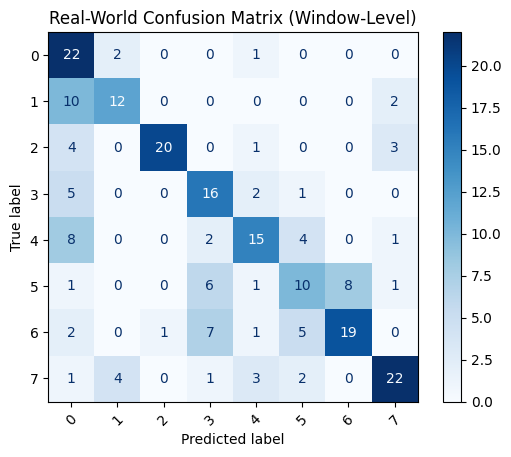

In [ ]:
## Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)

plt.title("Real-World Confusion Matrix (Window-Level)")
plt.show()


In [10]:
##File-Level Metrics(Majority Voting)

file_votes = defaultdict(list)

for true_label, pred_label in zip(y_test, y_pred):
    file_votes[true_label].append(pred_label)

final_preds = []
final_true = []

for true_label, preds in file_votes.items():
    majority = Counter(preds).most_common(1)[0][0]
    final_preds.append(majority)
    final_true.append(true_label)

print("FILE-LEVEL METRICS (Majority Voting)")
print("Accuracy :", accuracy_score(final_true, final_preds))
print("Precision:", precision_score(final_true, final_preds, average="macro"))
print("Recall   :", recall_score(final_true, final_preds, average="macro"))
print("F1 Score :", f1_score(final_true, final_preds, average="macro"))


FILE-LEVEL METRICS (Majority Voting)
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0
